**Notebook Setup**

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import warnings; warnings.simplefilter('ignore')

-------------------------------------

In [89]:
clean = pd.read_csv("..\Data\Comments\dataCleaning.csv")

In [90]:
clean.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,LengthSentence,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
1215,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Adie abenk23,0⃣1⃣ is the best 👍✅🔝,UgzIByym6x3_KeNfBFF4AaABAg,2019-01-17 17:15:00,2,0,legitimate,...,1,0,4,0.0,1.0,3,5,0,0.0,0.071429


In [91]:
clean

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,LengthSentence,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17 23:06:24,0,0,spam,...,1,1,0,0.000000,1.0,0,0,7,0.0,0.000000
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Akiru Syakir,Bantu subscribe youtube gw dong,UgwQM2OHIzkVDtu0PIN4AaABAg,2019-04-10 22:40:00,0,0,spam,...,1,0,4,0.000000,1.0,0,0,1,0.0,0.000000
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teguh Wage Prakoso,"hachimon tonkou, kalau buka gerbang ke 8 auto ...",Ugyh7dOOI2953Exf3cp4AaABAg.8tUY_eVh77e8tUhBosQJLg,2019-04-09 02:50:06,0,0,spam,...,1,0,9,0.100000,1.0,0,0,0,0.0,0.000000
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,hidayah,https://www.youtube.com/channel/UC_iQ1hcNxz1ir...,UgxA-h0VMWXoShPkFEZ4AaABAg,2019-04-10 12:25:49,0,0,spam,...,1,1,0,0.000000,1.0,0,0,7,0.0,0.000000
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Derisma Ae,"https://youtu.be/aS1FIPcCuh4 CH: Derisma ae, m...",UgybtnYbYjDF7YZJAdN4AaABAg,2019-04-15 16:00:05,0,0,spam,...,1,1,9,0.100000,1.0,0,0,17,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,agus muliandri,Top,UgxG_8lxSoZduOAiE-54AaABAg.8tXxFBA8lZa8tXzXBaY73i,2019-04-10 09:28:02,0,0,legitimate,...,1,0,0,0.000000,1.0,0,0,1,0.0,0.000000
2842,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,EXE HUMAN,Creator senior memang beda ya 😎,Ugx4Ep3GEADS4c_w5YF4AaABAg,2019-04-09 11:43:58,0,0,legitimate,...,1,0,5,0.166667,1.0,1,1,1,0.0,0.083333
2843,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Ni Luh Ayu Sibang Sri Padmayanti_056,Keunggulan dan kekurangan nge buat kita semua ...,UgzltfmrOp2dr3DbCPx4AaABAg,2019-04-11 13:48:07,0,0,legitimate,...,1,0,9,0.200000,1.0,0,0,1,0.0,0.125000
2844,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Brigita Deya 183,Keren parahhh,UgyaAGTI4x4ta4TE1cF4AaABAg,2019-04-09 10:20:06,0,0,legitimate,...,1,0,1,0.000000,1.0,0,0,1,0.0,0.000000


In [14]:
clean.describe()

,Likes,Reply_Count,LengthSentence,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
count,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000
mean,33.689037,0.380183,1.271258,0.315531,7.951160,0.090493,0.964883,0.511244,0.557273,6.614898,0.032290,0.064161
std,1631.334031,9.589659,0.819059,0.666194,14.042294,0.121797,0.105319,1.640346,1.740469,16.757297,0.147781,0.170714
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,4.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,9.000000,0.166667,1.000000,0.000000,0.000000,6.000000,0.000000,0.071429
max,87019.000000,488.000000,18.000000,16.000000,319.000000,1.000000,1.000000,42.000000,42.000000,411.000000,3.000000,2.000000


In [92]:
result = clean.copy()

In [93]:
result.columns

Index(['Video_Id', 'Tittle', 'Description', 'Name', 'Comment', 'Comment_Id',
       'Time', 'Likes', 'Reply_Count', 'Label', 'cleanComment', 'cleanDesc',
       'cleanTittle', 'LengthSentence', 'countUrl', 'WhiteSpacenum',
       'StopwordRatio', 'WorldDuplicateRatio', 'CountEmoji', 'CountNonAscii',
       'CountUpperLetters', 'SimilarityTitle', 'SimilarityDesc'],
      dtype='object')

In [94]:
VData =result.drop(['Video_Id', "Tittle", "Description", "Name", "Comment", "Time", "cleanComment", "cleanDesc", "cleanTittle"], axis=1)

In [95]:
VData = VData.set_index("Comment_Id")

In [96]:
label_encoder = LabelEncoder()

In [97]:
VData["Label"] = label_encoder.fit_transform(VData['Label'])

In [103]:
spam = VData[VData["Label"] == 1]
spam

,Likes,Reply_Count,Label,LengthSentence,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
Comment_Id,,,,,,,,,,,,,
Ugz-zdD0s87dSDzITuh4AaABAg,0,0,1,1,1,0,0.000000,1.000000,0,0,7,0.0,0.000000
UgwQM2OHIzkVDtu0PIN4AaABAg,0,0,1,1,0,4,0.000000,1.000000,0,0,1,0.0,0.000000
Ugyh7dOOI2953Exf3cp4AaABAg.8tUY_eVh77e8tUhBosQJLg,0,0,1,1,0,9,0.100000,1.000000,0,0,0,0.0,0.000000
UgxA-h0VMWXoShPkFEZ4AaABAg,0,0,1,1,1,0,0.000000,1.000000,0,0,7,0.0,0.000000
UgybtnYbYjDF7YZJAdN4AaABAg,0,0,1,1,1,9,0.100000,1.000000,0,0,17,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
UgzT66T9JkB3o6u6cNF4AaABAg,0,1,1,1,0,6,0.000000,1.000000,1,2,1,0.0,0.090909
UgxaK-di85EvEDdD0aF4AaABAg,0,0,1,1,1,0,0.000000,1.000000,0,0,3,0.0,0.000000
UgyCw1ji8uc7PC2pS4l4AaABAg,0,0,1,1,0,4,0.000000,1.000000,0,0,38,0.0,0.000000


In [47]:
SData = VData.drop(["Label"],axis=1)
SData = SData.set_index("Comment_Id")

In [48]:
SData

,Likes,Reply_Count,LengthSentence,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
Comment_Id,,,,,,,,,,,,
Ugz-zdD0s87dSDzITuh4AaABAg,0,0,1,1,0,0.000000,1.0,0,0,7,0.0,0.000000
UgwQM2OHIzkVDtu0PIN4AaABAg,0,0,1,0,4,0.000000,1.0,0,0,1,0.0,0.000000
Ugyh7dOOI2953Exf3cp4AaABAg.8tUY_eVh77e8tUhBosQJLg,0,0,1,0,9,0.100000,1.0,0,0,0,0.0,0.000000
UgxA-h0VMWXoShPkFEZ4AaABAg,0,0,1,1,0,0.000000,1.0,0,0,7,0.0,0.000000
UgybtnYbYjDF7YZJAdN4AaABAg,0,0,1,1,9,0.100000,1.0,0,0,17,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
UgxG_8lxSoZduOAiE-54AaABAg.8tXxFBA8lZa8tXzXBaY73i,0,0,1,0,0,0.000000,1.0,0,0,1,0.0,0.000000
Ugx4Ep3GEADS4c_w5YF4AaABAg,0,0,1,0,5,0.166667,1.0,1,1,1,0.0,0.083333
UgzltfmrOp2dr3DbCPx4AaABAg,0,0,1,0,9,0.200000,1.0,0,0,1,0.0,0.125000


In [49]:
def normalize(df, result):
    result = df.copy()
    for feature_name in result.columns:
        max_value = result[feature_name].max()
        min_value = result[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [50]:
scaledData=normalize(SData, SData)

In [51]:
scaledData

,Likes,Reply_Count,LengthSentence,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
Comment_Id,,,,,,,,,,,,
Ugz-zdD0s87dSDzITuh4AaABAg,0.0,0.0,0.0,0.0625,0.000000,0.000000,1.0,0.00000,0.00000,0.017032,0.0,0.000000
UgwQM2OHIzkVDtu0PIN4AaABAg,0.0,0.0,0.0,0.0000,0.012539,0.000000,1.0,0.00000,0.00000,0.002433,0.0,0.000000
Ugyh7dOOI2953Exf3cp4AaABAg.8tUY_eVh77e8tUhBosQJLg,0.0,0.0,0.0,0.0000,0.028213,0.100000,1.0,0.00000,0.00000,0.000000,0.0,0.000000
UgxA-h0VMWXoShPkFEZ4AaABAg,0.0,0.0,0.0,0.0625,0.000000,0.000000,1.0,0.00000,0.00000,0.017032,0.0,0.000000
UgybtnYbYjDF7YZJAdN4AaABAg,0.0,0.0,0.0,0.0625,0.028213,0.100000,1.0,0.00000,0.00000,0.041363,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
UgxG_8lxSoZduOAiE-54AaABAg.8tXxFBA8lZa8tXzXBaY73i,0.0,0.0,0.0,0.0000,0.000000,0.000000,1.0,0.00000,0.00000,0.002433,0.0,0.000000
Ugx4Ep3GEADS4c_w5YF4AaABAg,0.0,0.0,0.0,0.0000,0.015674,0.166667,1.0,0.02381,0.02381,0.002433,0.0,0.041667
UgzltfmrOp2dr3DbCPx4AaABAg,0.0,0.0,0.0,0.0000,0.028213,0.200000,1.0,0.00000,0.00000,0.002433,0.0,0.062500


In [52]:
scaledData.describe()

,Likes,Reply_Count,LengthSentence,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
count,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000,2846.000000
mean,0.000387,0.000779,0.015956,0.019721,0.024925,0.090493,0.964883,0.012172,0.013268,0.016095,0.010763,0.032080
std,0.018747,0.019651,0.048180,0.041637,0.044020,0.121797,0.105319,0.039056,0.041440,0.040772,0.049260,0.085357
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.006270,0.000000,1.000000,0.000000,0.000000,0.002433,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.012539,0.000000,1.000000,0.000000,0.000000,0.004866,0.000000,0.000000
75%,0.000011,0.000000,0.000000,0.062500,0.028213,0.166667,1.000000,0.000000,0.000000,0.014599,0.000000,0.035714
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


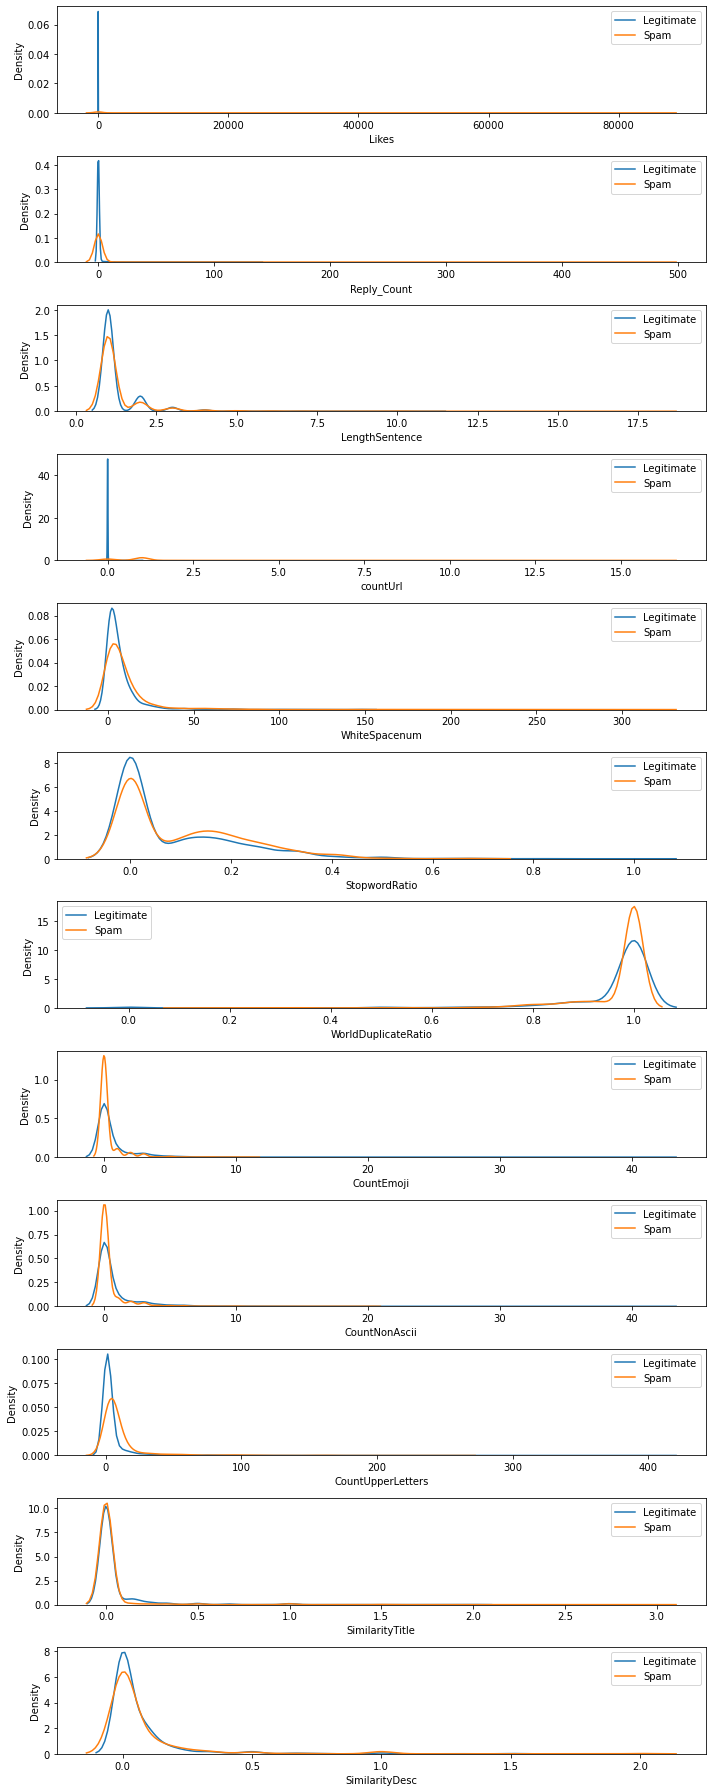

In [107]:
features = ["Likes", "Reply_Count", "LengthSentence", "countUrl", "WhiteSpacenum",
            "StopwordRatio", "WorldDuplicateRatio", "CountEmoji", "CountNonAscii",
            "CountUpperLetters", "SimilarityTitle", "SimilarityDesc"]

fig, axes = plt.subplots(len(features),1, figsize = (10,25))

for i in range(len(features)):
    sns.kdeplot(Legit[features[i]], ax = axes[i], label = 'Legitimate')
    sns.kdeplot(spam[features[i]], ax = axes[i], label = 'Spam')
    axes[i].set_xlabel(features[i])
    axes[i].legend()

plt.tight_layout()
plt.show()

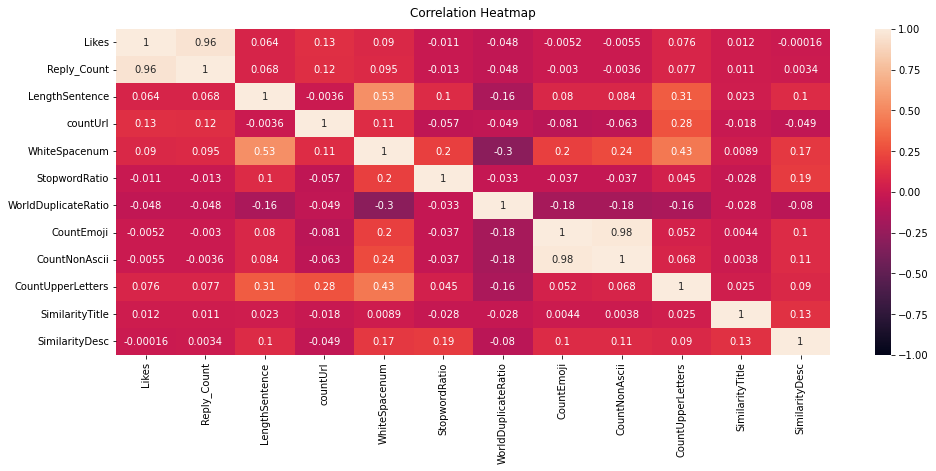

In [115]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(scaledData.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.savefig('..\Image\Heatmap Correlation.png', dpi=300, bbox_inches='tight')

In [111]:
features = ["Likes", "Reply_Count", "LengthSentence", "countUrl", "WhiteSpacenum",
            "StopwordRatio", "WorldDuplicateRatio", "CountEmoji", "CountNonAscii",
            "CountUpperLetters", "SimilarityTitle", "SimilarityDesc"]

def normalize(df, result):
    result = df.copy()
    for feature_name in features:
        max_value = result[feature_name].max()
        min_value = result[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [112]:
normData = normalize(clean, clean)

In [113]:
normData

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,LengthSentence,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,SimilarityTitle,SimilarityDesc
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17 23:06:24,0.0,0.0,spam,...,0.0,0.0625,0.000000,0.000000,1.0,0.00000,0.00000,0.017032,0.0,0.000000
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Akiru Syakir,Bantu subscribe youtube gw dong,UgwQM2OHIzkVDtu0PIN4AaABAg,2019-04-10 22:40:00,0.0,0.0,spam,...,0.0,0.0000,0.012539,0.000000,1.0,0.00000,0.00000,0.002433,0.0,0.000000
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teguh Wage Prakoso,"hachimon tonkou, kalau buka gerbang ke 8 auto ...",Ugyh7dOOI2953Exf3cp4AaABAg.8tUY_eVh77e8tUhBosQJLg,2019-04-09 02:50:06,0.0,0.0,spam,...,0.0,0.0000,0.028213,0.100000,1.0,0.00000,0.00000,0.000000,0.0,0.000000
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,hidayah,https://www.youtube.com/channel/UC_iQ1hcNxz1ir...,UgxA-h0VMWXoShPkFEZ4AaABAg,2019-04-10 12:25:49,0.0,0.0,spam,...,0.0,0.0625,0.000000,0.000000,1.0,0.00000,0.00000,0.017032,0.0,0.000000
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Derisma Ae,"https://youtu.be/aS1FIPcCuh4 CH: Derisma ae, m...",UgybtnYbYjDF7YZJAdN4AaABAg,2019-04-15 16:00:05,0.0,0.0,spam,...,0.0,0.0625,0.028213,0.100000,1.0,0.00000,0.00000,0.041363,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,agus muliandri,Top,UgxG_8lxSoZduOAiE-54AaABAg.8tXxFBA8lZa8tXzXBaY73i,2019-04-10 09:28:02,0.0,0.0,legitimate,...,0.0,0.0000,0.000000,0.000000,1.0,0.00000,0.00000,0.002433,0.0,0.000000
2842,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,EXE HUMAN,Creator senior memang beda ya 😎,Ugx4Ep3GEADS4c_w5YF4AaABAg,2019-04-09 11:43:58,0.0,0.0,legitimate,...,0.0,0.0000,0.015674,0.166667,1.0,0.02381,0.02381,0.002433,0.0,0.041667
2843,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Ni Luh Ayu Sibang Sri Padmayanti_056,Keunggulan dan kekurangan nge buat kita semua ...,UgzltfmrOp2dr3DbCPx4AaABAg,2019-04-11 13:48:07,0.0,0.0,legitimate,...,0.0,0.0000,0.028213,0.200000,1.0,0.00000,0.00000,0.002433,0.0,0.062500
2844,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Brigita Deya 183,Keren parahhh,UgyaAGTI4x4ta4TE1cF4AaABAg,2019-04-09 10:20:06,0.0,0.0,legitimate,...,0.0,0.0000,0.003135,0.000000,1.0,0.00000,0.00000,0.002433,0.0,0.000000


In [114]:
normData.to_csv("../Data/Comments/NormDataCleaning.csv", index=False)